# Ex05

#### Objective:
Your boss wants to make groups of type of customer to make a commercial targeting
with offers by e-mails (welcome offers for new customers, coupon to bring back old
customers, special status for loyal customers like: gold, silver, platinum ...)
- Make at least 4 groups (new customer, inactive customer, loyalty status: gold +
silver + platinum ...)
- You have to use a Clustering Algorithms
- Make graphic representations of the groups (minimum 2)

We will use clustering algorithms to group customers into distinct categories based on their behavior. The goal is to identify meaningful customer segments that can guide targeted marketing campaigns


First we import all the libraries:

In [9]:
# First of all, we have to import the necessary libraries
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import glob
import os
import numpy as np

Now let's connect with the DataBase:

In [10]:
DB_NAME = "piscineds"
USER = "ojimenez"
PASSWORD = "mysecretpassword"
HOST = "localhost"
PORT = "5432"

# Let's connect with a SQLAlchemy engine (With psycopg2 we have a Warning):
engine_url = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}"
engine = create_engine(engine_url)

try:
    with engine.connect() as connection:
        print("Connected to the database successfully!")
except Exception as e:
    print(f"Error connecting to the database: {e}")

Connected to the database successfully!


Great! Let's start:

In [11]:
query = """
    SELECT 
        purchase_months_category,
        customer_count,
        avg_purchase_months,
        avg_purchase_frequency,
        purchase_frequency
    FROM (
        SELECT 
            CASE
                WHEN purchase_months = 5 THEN 'loyal platinum'
                WHEN purchase_months IN (3, 4) THEN 'loyal'
                WHEN purchase_months = 2 THEN 'new customer'
                WHEN purchase_months = 1 AND NOT (purchase_month = 1 OR purchase_month = 2) THEN 'inactive'
                WHEN purchase_months = 1 THEN 'new customer'
            END AS purchase_months_category,
            COUNT(DISTINCT user_id) AS customer_count,
            AVG(purchase_months) AS avg_purchase_months,
            AVG(purchase_frequency) AS avg_purchase_frequency,
            AVG(purchase_frequency) AS purchase_frequency
        FROM (
            SELECT 
                user_id,
                COUNT(*) AS purchase_months,
                EXTRACT(MONTH FROM MIN(event_time)) AS purchase_month,
                COUNT(*) * 1.0 / COUNT(DISTINCT user_id) AS purchase_frequency
            FROM 
                customers
            WHERE 
                event_type = 'purchase'
            GROUP BY 
                user_id
        ) AS purchase_counts
        GROUP BY 
            purchase_months_category
        HAVING 
            AVG(purchase_months) BETWEEN 0 AND 6
    ) AS final_result
    ORDER BY 
        customer_count;
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()
print(data.head())


Query executed successfully :)
  purchase_months_category  customer_count  avg_purchase_months  \
0                 inactive            6954             1.000000   
1           loyal platinum            7748             5.000000   
2             new customer           16123             1.721516   
3                    loyal           20526             3.467505   

   avg_purchase_frequency  purchase_frequency  
0                1.000000            1.000000  
1                5.000000            5.000000  
2                1.721516            1.721516  
3                3.467505            3.467505  


  purchase_months_category  customer_count  avg_purchase_months  \
0                 inactive            6954             1.000000   
1           loyal platinum            7748             5.000000   
2             new customer           16123             1.721516   
3                    loyal           20526             3.467505   

   avg_purchase_frequency  purchase_frequency  cluster  
0                1.000000            1.000000        2  
1                5.000000            5.000000        0  
2                1.721516            1.721516        1  
3                3.467505            3.467505        3  


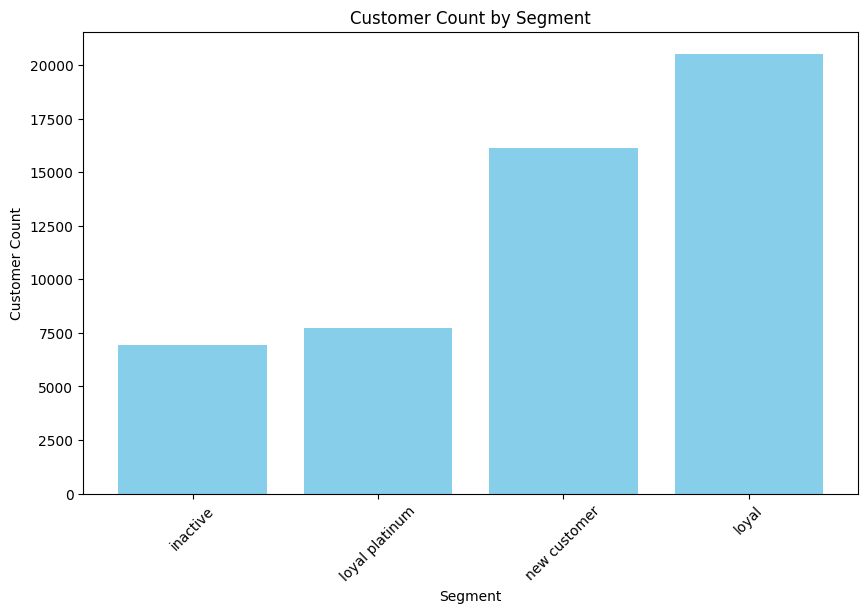

In [28]:
# This first graphic:
plt.figure(figsize=(10, 6))
plt.bar(data['purchase_months_category'], data['customer_count'], color='skyblue')
plt.title('Customer Count by Segment')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.show()

Now we have the data visualised. Let's follow with the  Clustering Algorithms in order to group our data into meaningful clusters.

__Cluster Algorithm__: A clustering algorithm is an unsupervised learning technique that groups similar data based on their features.


__Objective:__ In our case, the data contains information about different customer segments (purchase_months_category) and their associated metrics (avg_purchase_months, avg_purchase_frequency,...).
The goal of clustering is to identify patterns or natural groupings in the data that may not be immediately obvious.

#### Next Step:
Now we prepare the columns to use a Cluster Algorithm

In [30]:
query = """
    SELECT 
        user_id,
        COUNT(*) AS avg_purchase_months,
        COUNT(*) * 1.0 / COUNT(DISTINCT user_id) AS avg_purchase_frequency
    FROM 
        customers
    WHERE 
        event_type = 'purchase'
    GROUP BY 
        user_id
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()
print(data.head(10))

Query executed successfully :)
    user_id  avg_purchase_months  avg_purchase_frequency
0   9794320                    4                     4.0
1  10079204                    2                     2.0
2  10280338                   86                    86.0
3  12055855                    4                     4.0
4  12936739                    2                     2.0


In [34]:
#print(data.head(20))

# Normaliza los datos para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['avg_purchase_months', 'avg_purchase_frequency']])

print("Datos normalizados para KMeans:")
print(X_scaled[:5])

     user_id  avg_purchase_months  avg_purchase_frequency  cluster
0    9794320                    4                     4.0        0
1   10079204                    2                     2.0        0
2   10280338                   86                    86.0        2
3   12055855                    4                     4.0        0
4   12936739                    2                     2.0        0
5   15400971                    3                     3.0        0
6   15781728                    2                     2.0        0
7   19762782                    8                     8.0        0
8   20554973                    7                     7.0        0
9   23633626                    8                     8.0        0
10  25300038                    5                     5.0        0
11  25392526                    3                     3.0        0
12  27443691                    5                     5.0        0
13  27756757                    1                     1.0     

Let's apply the __KMeans__ algorithm

In [78]:
# Aplica KMeans con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Agrega los centroides de los clusters al DataFrame
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=['avg_purchase_months', 'avg_purchase_frequency'])

print("Centroides de los clusters:")
print(centroids_df)

Centroides de los clusters:
   avg_purchase_months  avg_purchase_frequency
0             6.112136                6.112136
1            30.266272               30.266272
2            83.963293               83.963293
3           230.525140              230.525140


manual_cluster
Inactive          92736
Loyal             14872
New Customer       2697
Loyal Platinum      179
Name: count, dtype: int64


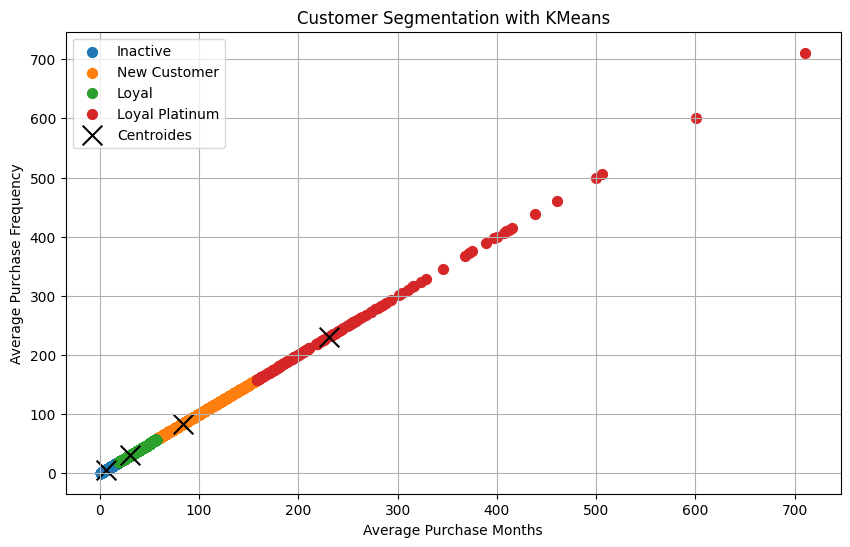

In [79]:
# Crear una nueva columna para la segmentación manual
data['manual_cluster'] = data['cluster'].map({
    0: "Inactive",
    1: "Loyal",
    2: "New Customer",
    3: "Loyal Platinum"
})

# We count the amount of people per cluster
cluster_sizes = data['manual_cluster'].value_counts()
print(cluster_sizes)

# Gráfico de dispersión con los clusters
plt.figure(figsize=(10, 6))
for cluster_name in ["Inactive", "New Customer", "Loyal", "Loyal Platinum"]:
    cluster_data = data[data['manual_cluster'] == cluster_name]
    #size = cluster_sizes[cluster]
    plt.scatter(
        cluster_data['avg_purchase_months'],
        cluster_data['avg_purchase_frequency'],
        #label=cluster_names[cluster],
        label=cluster_name,
        alpha=1,
        s=50
    )

# Añade los centroides al gráfico
plt.scatter(
    centroids_df['avg_purchase_months'],
    centroids_df['avg_purchase_frequency'],
    c='black',
    marker='x',
    s=200,
    label='Centroides'
)

plt.title('Customer Segmentation with KMeans')
plt.xlabel('Average Purchase Months')
plt.ylabel('Average Purchase Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
hist, x_edges, y_edges = np.histogram2d(
    data['avg_purchase_months'],
    data['avg_purchase_frequency'],
    bins=50  # Número de divisiones en cada eje
)

# Centros de las celdas para graficar
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)
Z = hist.T  # Transpone para que coincida con las dimensiones

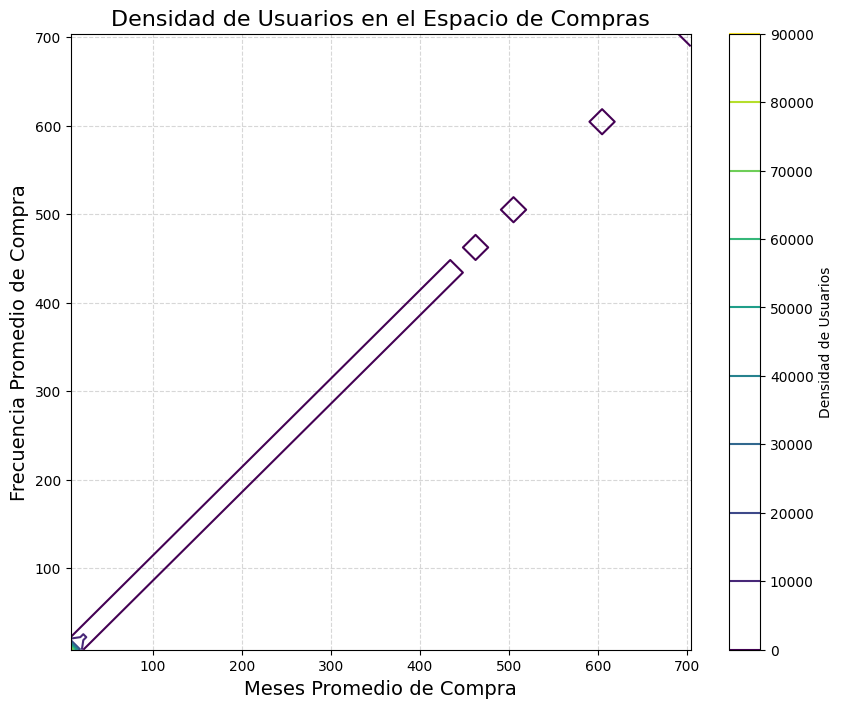

In [82]:
plt.figure(figsize=(10, 8))
cp = plt.contour(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cp, label='Densidad de Usuarios')
plt.title('Densidad de Usuarios en el Espacio de Compras', fontsize=16)
plt.xlabel('Meses Promedio de Compra', fontsize=14)
plt.ylabel('Frecuencia Promedio de Compra', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [6]:
batch_size = 2000000
offset = 0
batch_number = 0

# We create the folder
if not os.path.exists('batches'):
    os.makedirs('batches')

while True:
    query = f"""
        SELECT 
            user_id,
            event_type,
            product_id,
            price,
            DATE(event_time) AS event_date
        FROM 
            customers
        ORDER BY 
            user_id, event_time
        LIMIT {batch_size} OFFSET {offset};
    """
    
    batch_df = pd.read_sql(query, engine)
    if batch_df.empty:
        break

    batch_aggregated = batch_df.groupby('user_id').agg({
        'event_type': lambda x: (x == 'purchase').sum(),
        'price': 'mean',
        'event_date': ['nunique', 'max']
    })

    batch_aggregated.columns = ['total_purchases', 'avg_spending', 'active_days', 'last_interaction']
    batch_aggregated = batch_aggregated.reset_index()
    
    batch_aggregated['user_index'] = range(len(batch_aggregated))
    batch_aggregated = batch_aggregated[['user_index', 'total_purchases', 'avg_spending', 'active_days', 'last_interaction']]
    
    batch_aggregated.to_csv(f'batches/batch_{batch_number}.csv', index=False)
    print(f"Processed batch {batch_number}")

    offset += batch_size
    batch_number += 1

print('Finished! All data processed')

KeyboardInterrupt: 

In [88]:
# Now we merge all the batches
files = glob.glob('batches/batch_*.csv')
final_data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
final_data.to_csv('batches/full_aggregated_data.csv', index=False)
print("All batches combined successfully!")

final_data = pd.read_csv('batches/full_aggregated_data.csv')

# We select the trainable features
features = final_data[['event_type', 'price', 'event_date']]

# Normalize
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
print("Data Normalized")

All batches combined successfully!
Data Normalized


Now we use the __Mini-Batch K-Means__ algorithm:

In [89]:
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

print("Clusters asignados:", clusters)

cluster_stats = {}

for cluster_id in range(4):
    cluster_data = normalized_features[clusters == cluster_id]

    cluster_stats[cluster_id] = {
        'mean_event_type': np.mean(cluster_data[:, 0]), #event_type
        'mean_price': np.mean(cluster_data[:, 1]), #price
        'mean_event_date': np.mean(cluster_data[:, 2]) #event_date
    }

Clusters asignados: [1 2 2 ... 2 1 2]


Now we have to analize the results:

In [90]:
# We convert statistics into a DataFrame
cluster_stats_df = pd.DataFrame.from_dict(cluster_stats, orient='index')
cluster_stats_df.reset_index(inplace=True)
cluster_stats_df.rename(columns={'index': 'cluster'}, inplace=True)

print(cluster_stats_df)

   cluster  mean_event_type  mean_price  mean_event_date
0        0         4.367021   -0.304198         4.665005
1        1        -0.070808    0.369488         0.213602
2        2        -0.091932   -0.357539        -0.197148
3        3        -0.138172    3.726692        -0.142111


In [97]:
def assign_cluster(stats):
    if stats['mean_event_type'] > 1 and stats['mean_event_date'] > 1:
        return "Loyal"
    elif stats['mean_price'] > 2 and stats['mean_event_type'] < 0:
        return "Loyal Platinum"
    elif stats['mean_event_type'] < -0.5 and stats['mean_price'] < -0.5 and stats['mean_event_date'] < 0.5:
        return "Inactive"
    else:
        return "New Customer"

cluster_stats_df['cluster_name'] = cluster_stats_df.apply(assign_cluster, axis=1)
print(cluster_stats_df)

   cluster  mean_event_type  mean_price  mean_event_date    cluster_name
0        0         4.367021   -0.304198         4.665005           Loyal
1        1        -0.070808    0.369488         0.213602    New Customer
2        2        -0.091932   -0.357539        -0.197148    New Customer
3        3        -0.138172    3.726692        -0.142111  Loyal Platinum


Now let's go with the plots:

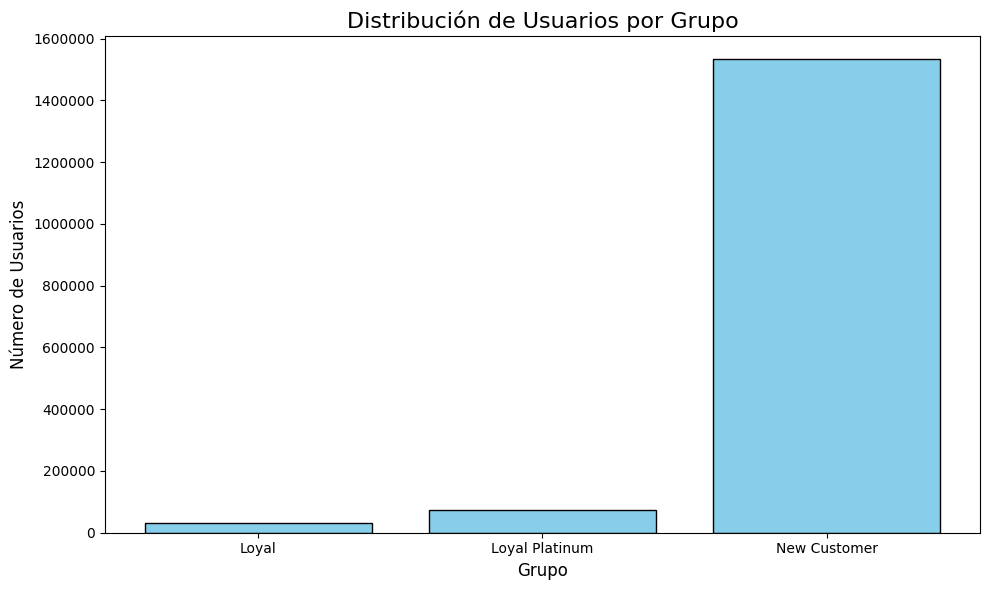

In [98]:
cluster_stats_df['cluster_name'] = cluster_stats_df.apply(assign_cluster, axis=1)

# Agregamos las asignaciones de cluster al DataFrame final
final_data['cluster'] = clusters

# Mapeamos los nombres descriptivos de los clusters
cluster_name_map = cluster_stats_df.set_index('cluster')['cluster_name'].to_dict()
final_data['cluster_name'] = final_data['cluster'].map(cluster_name_map)

# Contamos cuántos usuarios hay en cada grupo
cluster_counts_named = final_data['cluster_name'].value_counts().sort_index()

# Generamos el gráfico
plt.figure(figsize=(10, 6))
plt.ticklabel_format(style='plain', axis='y')  # Desactivar notación científica

plt.bar(
    cluster_counts_named.index,
    cluster_counts_named.values,
    color='skyblue',
    edgecolor='black'
)

plt.title('Distribución de Usuarios por Grupo', fontsize=16)
plt.xlabel('Grupo', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.xticks(rotation=0, fontsize=10)  # Rotar etiquetas si son largas
plt.tight_layout()  # Ajustar diseño para evitar recortes
plt.show()